# 我放弃了一 key 到底

本题的关键在于理解WOTS算法如何工作。本题的WOTS会先生成私钥，将私钥哈希20次作为公钥，将输入映射到一个0-20的数列。假设数列第i位的值是a[i]，它的签名s[i]是对sk[i]哈希20-a[i]次的结果；校验时再哈希a[i]次，应该正好得到公钥。

Merkel Tree的部分并不重要，本题算法之所以有问题是因为我们可以使用同一个key对不同数据进行加密（什么，不会有人不知道python数组负数索引吧）。如果哈希参数已知，攻击者能够自行进行哈希操作，那任意其它数列第i位小于a[i]都是不安全的，我们可以通过多哈希几次伪造这一位的签名。

先把`utils.py`里用得上的部分提取出来，然后加点print语句：

In [1]:
from Crypto.Util.number import bytes_to_long
from hashlib import shake_128
from secrets import token_bytes
from math import floor, ceil, log2
import enum

m = 256
w = 21
n = 128
l1 = ceil(m / log2(w))
l2 = floor(log2(l1 * (w - 1)) / log2(w)) + 1
l = l1 + l2
print(f"[WOTS]: m={m}, w={w}, n={n}, l1={l1}, l2={l2}, l={l}")


class HashType(enum.IntEnum):
    MSG = 0
    WOTS_PK = 1
    WOTS_CHAIN = 2
    TREE_NODE = 3


def F(data: bytes, seed: bytes, length: int, type: int) -> bytes:
    hasher = shake_128(seed + bytes([type]) + data)
    return hasher.digest(length)


class WOTS:
    def __init__(self, seed: bytes):
        self.seed = seed
        self.sk = [token_bytes(n // 8) for _ in range(l)]
        self.pk = [WOTS.chain(sk, w - 1, seed) for sk in self.sk]

    def sign(self, digest: bytes) -> bytes:
        assert 8 * len(digest) == m
        d1 = WOTS.pack(bytes_to_long(digest), l1, w)
        checksum = sum(w - 1 - i for i in d1)
        d2 = WOTS.pack(checksum, l2, w)
        d = d1 + d2

        print(f"[WOTS]:signing digest {digest.hex()} d: {d}")
        print(f"[WOTS]:d1: {d1}")
        print(f"[WOTS]:d2: {d2}")

        sig = [WOTS.chain(self.sk[i], w - d[i] - 1, self.seed) for i in range(l)]
        return sig

    def sign_d(self, d) -> bytes:
        sig = [WOTS.chain(self.sk[i], w - d[i] - 1, self.seed) for i in range(l)]
        return sig

    def get_pubkey_hash(self) -> bytes:
        return F(b"".join(self.pk), self.seed, 16, HashType.WOTS_PK)

    def get_privatekey_hash(self) -> bytes:
        return F(b"".join(self.sk), self.seed, 16, HashType.WOTS_PK)

    @staticmethod
    def pack(num: int, length: int, base: int) -> list[int]:
        packed = []
        while num > 0:
            packed.append(num % base)
            num //= base
        if len(packed) < length:
            packed += [0] * (length - len(packed))
        return packed

    @staticmethod
    def chain(x: bytes, n: int, seed: bytes) -> bytes:
        if n == 0:
            return x
        x = F(x, seed, 16, HashType.WOTS_CHAIN)
        return WOTS.chain(x, n - 1, seed)

    @staticmethod
    def verify(digest: bytes, sig: bytes, seed: bytes) -> bytes:
        d1 = WOTS.pack(bytes_to_long(digest), l1, w)
        checksum = sum(w - 1 - i for i in d1)
        d2 = WOTS.pack(checksum, l2, w)
        d = d1 + d2

        sig_pk = [WOTS.chain(sig[i], d[i], seed) for i in range(l)]
        return F(b"".join(sig_pk), seed, 16, HashType.WOTS_PK)


class MerkleTree:
    def __init__(self, height: int, seed: bytes):
        self.h = height
        self.seed = seed
        self.keys = [WOTS(seed) for _ in range(2**height)]
        self.tree = []
        self.root = self.build_tree([key.get_pubkey_hash() for key in self.keys])

    def build_tree(self, leaves: list[bytes]) -> bytes:
        self.tree.append(leaves)

        if len(leaves) == 1:
            return leaves[0]

        parents = []
        for i in range(0, len(leaves), 2):
            left = leaves[i]
            if i + 1 < len(leaves):
                right = leaves[i + 1]
            else:
                right = leaves[i]
            hasher = F(left + right, self.seed, 16, HashType.TREE_NODE)
            parents.append(hasher)

        return self.build_tree(parents)

    def sign(self, index: int, msg: bytes) -> list:
        digest = F(msg, self.seed, 32, HashType.MSG)
        key = self.keys[index]
        print(
            f"[MerkleTree]:signing index {index} for msg {msg}"
            f" key pk hash: {key.get_pubkey_hash().hex()}"
            f" key sk[0]: {key.sk[0].hex()}"
            f" digest: {digest.hex()}"
        )
        wots_sig = key.sign(digest)
        sig = [wots_sig]
        # it only applies to index! so for every index whatever the message is,
        # the second part will be the same
        for i in range(self.h):  # bitwise signing
            leaves = self.tree[i]
            u = index >> i
            if u % 2 == 0:
                if u + 1 < len(leaves):
                    sig.append((0, leaves[u + 1]))
                else:
                    sig.append((0, leaves[u]))
            else:
                sig.append((1, leaves[u - 1]))
        return sig

    @staticmethod
    def verify(root, sig: list, msg: bytes, seed: bytes) -> bytes:
        digest = F(msg, seed, 32, HashType.MSG)  # digest实际上没法构造，hash太强了
        wots_sig = sig[0]
        sig = sig[1:]
        pk_hash = WOTS.verify(digest, wots_sig, seed)
        computed_root = pk_hash
        for side, leaf in sig:
            if side == 0:
                computed_root = F(computed_root + leaf, seed, 16, HashType.TREE_NODE)
            else:
                computed_root = F(leaf + computed_root, seed, 16, HashType.TREE_NODE)
        return root == computed_root


def serialize_signature(sig) -> bytes:
    data = b"".join(sig[0])
    for side, node in sig[1:]:
        data += bytes([side]) + node
    return data


def deserialize_signature(data: bytes):
    sig = []
    sig.append([data[i * 16 : (i + 1) * 16] for i in range(l)])
    data = data[l * 16 :]
    height = (len(data)) // 17
    for i in range(height):
        side = data[i * 17]
        node = data[i * 17 + 1 : (i + 1) * 17]
        sig.append((side, node))
    return sig


[WOTS]: m=256, w=21, n=128, l1=59, l2=3, l=62


让我们先观察一下加密流程。先固定SEED，建个树：

In [2]:
SEED = bytes.fromhex("e83669f7134e8e902d7efc7a8f1f1726")

height = 8
tree = MerkleTree(height, SEED)
root = tree.root
print(root)

b'\xa8Ln\x1a\x83\x953l\xb1\x7f\xb1\x97\xb7\x94|H'


写一个_pack_msg函数对输入进行序列化，它的参数随Seed改变。

In [3]:
REAL_MSG = b"Give me the flag"


def _pack_msg(msg):
    digest = F(msg, SEED, 32, HashType.MSG)
    d1 = WOTS.pack(bytes_to_long(digest), l1, w)
    checksum = sum(w - 1 - i for i in d1)
    d2 = WOTS.pack(checksum, l2, w)
    return d1 + d2


dT = _pack_msg(REAL_MSG)
dT

[19,
 2,
 15,
 20,
 17,
 17,
 6,
 6,
 8,
 10,
 5,
 13,
 20,
 8,
 2,
 8,
 10,
 2,
 12,
 12,
 2,
 11,
 12,
 8,
 2,
 9,
 6,
 7,
 3,
 11,
 14,
 17,
 8,
 4,
 8,
 3,
 3,
 2,
 0,
 15,
 5,
 15,
 1,
 3,
 1,
 10,
 7,
 10,
 10,
 10,
 5,
 0,
 9,
 17,
 0,
 6,
 12,
 14,
 1,
 15,
 11,
 1]

如果我们能对一个Key签名两次，对于任意序列化后的字符串x，我们有可能构造出x1, x2, 使得对于任意i, max(x1[i], x2[i]) >= x[i]，这就给了我们伪造签名的机会。我们可以生成大量随机字符串，搜索是否存在合法的x1, x2。

In [4]:
# find 2 groups of inputs,
# that min(d1[i], d2[i]) <= dT[i] for all i

import random
import string

# pack_msg compiles a string into a list of integers in [0, 21)

def _generate_random_string(length = 10):
    # Generate a random string of all printable characters
    characters = string.ascii_letters + string.digits + string.punctuation + ' '
    return ''.join(random.choice(characters) for _ in range(length))

# 生成大量随机字符串并一次性把他们序列化
strings = [_generate_random_string(20) for _ in range(6000000)]
d_list = [_pack_msg(s.encode()) for s in strings]

masks_to_indices = {}
for i, d in enumerate(d_list):
    mask = 0
    for k in range(l):
        if d[k] < dT[k]:  # d[k] should >= dT[k]
            mask |= (1 << k)
    if mask not in masks_to_indices:
        masks_to_indices[mask] = i

unique_masks = [(k, bin(k).count('1')) for k in masks_to_indices.keys()]
# 先排序，优先搜索成立位数多的串
unique_masks.sort(key=lambda x: x[1])
print(unique_masks[:10])

_min_bits = l + 1
_str1 = None
_str2 = None

for i in range(len(unique_masks) // 2): # 优化，减少内层循环次数
    for j in range(i, len(unique_masks)):
        mask1 = unique_masks[i][0]
        mask2 = unique_masks[j][0]
        bits1 = unique_masks[i][1]
        bits2 = unique_masks[j][1]
        if bits1 + bits2 > l:  # 优化，肯定不可能成立就直接剪枝
            break
        _now_bits = bin(mask1 & mask2).count("1")
        if _now_bits < _min_bits:
            _min_bits = _now_bits
            print(f"New min bits: {_min_bits}")
        if _now_bits == 0:
            print(f"Found masks: {mask1:0{l}b}, {mask2:0{l}b}")
            index1 = masks_to_indices[mask1]
            index2 = masks_to_indices[mask2]
            str1 = strings[index1]
            str2 = strings[index2]
            _str1 = str1
            _str2 = str2
            print(f"Found strings:\n{str1}\n{str2}")
            break
    if _min_bits == 0:
        break
print(f"Found strings:\n{_str1}\n{_str2}")

KeyboardInterrupt: 

In [5]:
str1 = "l-SS!9=?D6OlE\pVd_`0"
str2 = '#M=r>_fc\IFU]"q-</EI'
d1 = _pack_msg(str1.encode())
d2 = _pack_msg(str2.encode())

d1_sign_shifted = []
d2_sign_shifted = []

for idx in range(l):
    if d1[idx] >= dT[idx]:
        d1_sign_shifted.append(d1[idx] - dT[idx])
        d2_sign_shifted.append(None)
    else:
        d1_sign_shifted.append(None)
        d2_sign_shifted.append(d2[idx] - dT[idx])
        
d1_sign_shifted, d2_sign_shifted

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\hrz\AppData\Local\Temp\ipykernel_24856\3418608460.py:1: SyntaxWarning: invalid escape sequence '\p'
  str1 = "l-SS!9=?D6OlE\pVd_`0"
C:\Users\hrz\AppData\Local\Temp\ipykernel_24856\3418608460.py:2: SyntaxWarning: invalid escape sequence '\I'
  str2 = '#M=r>_fc\IFU]"q-</EI'


([0,
  14,
  None,
  None,
  0,
  1,
  10,
  4,
  None,
  2,
  13,
  0,
  0,
  2,
  9,
  6,
  10,
  16,
  None,
  7,
  9,
  None,
  5,
  1,
  9,
  3,
  6,
  1,
  12,
  None,
  None,
  None,
  3,
  3,
  4,
  13,
  None,
  16,
  19,
  2,
  12,
  4,
  18,
  10,
  19,
  1,
  None,
  2,
  7,
  8,
...
  None,
  None,
  None,
  None,
  None,
  None,
  0,
  None,
  None,
  5,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  4,
  6,
  2,
  None,
  None,
  None,
  None,
  5,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  8,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  0])

In [6]:
IDX = 2
signT = tree.keys[IDX].sign_d(dT)
sign1 = tree.keys[IDX].sign_d(d1)
sign2 = tree.keys[IDX].sign_d(d2)
signMock = []

for i in range(l):
    if d1_sign_shifted[i] is not None:
        signMock.append(WOTS.chain(sign1[i], d1_sign_shifted[i], SEED))
    else:
        signMock.append(WOTS.chain(sign2[i], d2_sign_shifted[i], SEED))

for i in range(l):
    assert signMock[i] == signT[i], f"Index {i} mismatch"
print("All matched!")

All matched!


实际上可能不同的seed求解难度差距很大，我们可能需要多尝试几次。以下是完整的pwn代码：

In [ ]:
import threading
import time
from pwn import *


TOKEN = "PUT_YOUR_TOKEN_HERE"
HOST = "prob18.geekgame.pku.edu.cn"
PORT = 10018


def receive_till_eof() -> bytes:
    data = b""
    while True:
        try:
            chunk = conn.recv(timeout=1)
            if not chunk:
                break
            data += chunk
        except:
            break
    return data


# --- 心跳函数 ---
def heartbeat(conn_obj: tube):
    """
    在后台每60秒发送一次 "0\\n" 来保持连接。不然终端机会断开连接。
    """
    try:
        while True:
            time.sleep(30)

            # 发送心跳包
            # pwnlib的send/recv是线程安全的 (有锁)
            conn_obj.sendline(b"0")
            log.info("Heartbeat sent '0\\n'")
            # recv till eof to clear any response
            receive_till_eof()

    except (EOFError, ConnectionResetError):
        log.warn("Heartbeat thread: Connection closed.")
    except Exception as e:
        log.error(f"Heartbeat thread error: {e}")


# --- PwnTools 连接 ---
# set debug
context.log_level = "debug"
conn = remote(HOST, PORT)
conn.recvuntil(b"token:")
conn.sendline(TOKEN.encode())

hb_thread = threading.Thread(target=heartbeat, args=(conn,), daemon=True)
hb_thread.start()


def _parse_seed(lines: str):
    for l in lines.splitlines():
        if l.startswith("Seed: "):
            return bytes.fromhex(l[len("Seed: ") :])


# read lines and parse seed
data = b""
while True:
    line = conn.recvline()
    data += line
    if b"Public key (root): " in line:
        break

SEED = _parse_seed(data.decode())
if SEED is None:
    log.error("Failed to parse SEED")
    exit(1)
print(f"Parsed SEED: {SEED.hex()}")

# send \0
conn.sendline(b"0")
receive_till_eof()

# %%
from utils import *

REAL_MSG = b"Give me the flag"


def _pack_msg(msg):
    digest = F(msg, SEED, 32, HashType.MSG)
    d1 = WOTS.pack(bytes_to_long(digest), l1, w)
    checksum = sum(w - 1 - i for i in d1)
    d2 = WOTS.pack(checksum, l2, w)
    return d1 + d2


dT = _pack_msg(REAL_MSG)
dT

# %%
import random
import string

# pack_msg compiles a string into a list of integers in [0, 21)


def _generate_random_string(length=10):
    # Generate a random string of all printable characters
    characters = string.ascii_letters + string.digits + string.punctuation + " "
    return "".join(random.choice(characters) for _ in range(length))


print("Generating random strings...")
strings = [_generate_random_string(20) for _ in range(6000000)]
print("Packing random strings...")
d_list = [_pack_msg(s.encode()) for s in strings]

masks_to_indices = {}
for i, d in enumerate(d_list):
    mask = 0
    for k in range(l):
        if d[k] < dT[k]:  # d[k] should >= dT[k]
            mask |= 1 << k
    if mask not in masks_to_indices:
        masks_to_indices[mask] = i

unique_masks = [(k, bin(k).count("1")) for k in masks_to_indices.keys()]
# sort unique_masks by number of set bits
unique_masks.sort(key=lambda x: x[1])
print(unique_masks[:10])

# %%

_min_bits = l + 1
_str1 = None
_str2 = None

for i in range(len(unique_masks) // 2):
    for j in range(i, len(unique_masks)):
        mask1 = unique_masks[i][0]
        mask2 = unique_masks[j][0]
        bits1 = unique_masks[i][1]
        bits2 = unique_masks[j][1]
        if bits1 + bits2 > l:
            break
        _now_bits = bin(mask1 & mask2).count("1")
        if _now_bits < _min_bits:
            _min_bits = _now_bits
            print(f"New min bits: {_min_bits}")
        if _now_bits == 0:
            print(f"Found masks: {mask1:0{l}b}, {mask2:0{l}b}")
            index1 = masks_to_indices[mask1]
            index2 = masks_to_indices[mask2]
            str1 = strings[index1]
            str2 = strings[index2]
            _str1 = str1
            _str2 = str2
            print(f"Found strings:\n{str1}\n{str2}")
            break
    if _min_bits == 0:
        break
print(f"Found strings:\n{_str1}\n{_str2}")

d1 = _pack_msg(_str1.encode())
d2 = _pack_msg(_str2.encode())

d1_sign_shifted = []
d2_sign_shifted = []

for idx in range(l):
    if d1[idx] >= dT[idx]:
        d1_sign_shifted.append(d1[idx] - dT[idx])
        d2_sign_shifted.append(None)
    else:
        d1_sign_shifted.append(None)
        d2_sign_shifted.append(d2[idx] - dT[idx])

print(d1_sign_shifted, d2_sign_shifted)

INDEX = 2

# send 1\n
conn.sendline(b"1")
# wait for "Index: "
conn.recvuntil(b"Index: ")
# send index of 2
conn.sendline(str(INDEX).encode())
# wait for "Message: "
conn.recvuntil(b"Message: ")
# send _str1
conn.sendline(_str1.encode())
# receive signature
sig1_hex = conn.recvline().strip()
sig1 = deserialize_signature(bytes.fromhex(sig1_hex.decode()))
print(f"Received signature 1: {sig1_hex.decode()}")
# send 1\n
conn.sendline(b"1")
# wait for "Index: "
conn.recvuntil(b"Index: ")
# send index of 2
conn.sendline(str(INDEX - 256).encode())
# wait for "Message: "
conn.recvuntil(b"Message: ")
# send _str2
conn.sendline(_str2.encode())
# receive signature
sig2_hex = conn.recvline().strip()
sig2 = deserialize_signature(bytes.fromhex(sig2_hex.decode()))
print(f"Received signature 2: {sig2_hex.decode()}")

# %%
sign1 = sig1[0]
sign2 = sig2[0]

print("Constructing forged signature...")

signMock = []
for i in range(l):
    if d1_sign_shifted[i] is not None:
        signMock.append(WOTS.chain(sign1[i], d1_sign_shifted[i], SEED))
    else:
        signMock.append(WOTS.chain(sign2[i], d2_sign_shifted[i], SEED))

_sig_to_send = [signMock] + sig1[1:]

print("Mock signature constructed", _sig_to_send)

# send line

conn.sendline(b"2")
# wait for "Signature: "
conn.recvuntil(b"Signature: ")
conn.sendline(serialize_signature(_sig_to_send).hex().encode())
# receive response
response = conn.recvline().strip()
print(f"Response: {response.decode()}")

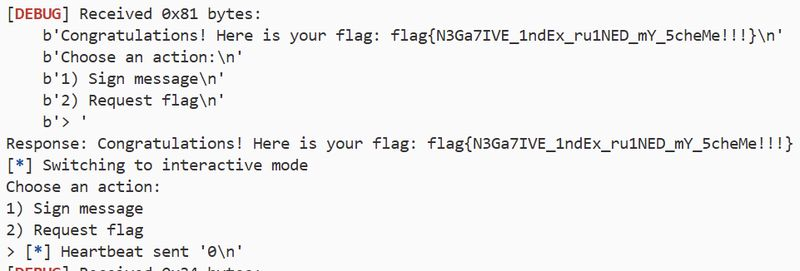